<a href="https://colab.research.google.com/github/haleyrx/qe_project/blob/main/transquest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prep**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/CS7643

/content/gdrive/MyDrive/CS7643


In [ ]:
# ! git clone https://2726c3be06d254f6092d9413236205338399aed0@github.com/haleyrx/qe_project

fatal: destination path 'qe_project' already exists and is not an empty directory.


In [3]:
!ls

colab_setup.ipynb  CS7643_HW4  qe_project


In [3]:
%cd qe_project
# ! git pull

/content/gdrive/MyDrive/CS7643/qe_project


In [5]:
!pip install sentencepiece
!pip install transformers==3


     |████████████████████████████████| 1.2MB 17.7MB/s 
     |████████████████████████████████| 757kB 18.5MB/s 
     |████████████████████████████████| 3.0MB 55.5MB/s 
     |████████████████████████████████| 901kB 51.8MB/s 


In [4]:
!nvidia-smi

Mon Apr 19 18:36:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%pwd

'/content/gdrive/MyDrive/CS7643/qe_project'

### Set up parameters

In [6]:
SEED = 777
RESULT_FILE = 'si-en_result.tsv'
METRICS_FILE = 'si-en_metrics.txt'
BEST_MODEL_FILE = 'si-en_best_model.bin'
MODEL_TYPE = 'xlmroberta'
MODEL_NAME = 'xlm-roberta-large'
TRAIN_DATA = 'si-en/train.sien.df.short.tsv'
DEV_DATA = 'si-en/dev.sien.df.short.tsv'
TEST_DATA = 'si-en/test20.sien.df.short.tsv'

# Model parameters
args = {
    'data_dir': './data/',
    'output_dir': './results/',
    'best_model_dir': './best_models/',
  
    'max_seq_length': 128,
    'train_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'eval_batch_size': 8,
    'num_train_epochs': 3,
    'weight_decay': 0,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.1,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,
    "manual_seed": SEED,

}

In [7]:
# Get relevant paths

import os 

train_path = os.path.join(args['data_dir'], TRAIN_DATA)
dev_path = os.path.join(args['data_dir'], DEV_DATA)
test_path = os.path.join(args['data_dir'], TEST_DATA)
best_model_path = os.path.join(args['best_model_dir'], BEST_MODEL_FILE)
results_path = os.path.join(args['output_dir'], RESULT_FILE)
metrics_path = os.path.join(args['output_dir'], METRICS_FILE)


In [8]:
train_path

'./data/si-en/train.sien.df.short.tsv'

## Read in Data

In [9]:
import csv
import pandas as pd

# function adapted from https://github.com/TharinduDR/
def read_file(path, index='index'):
    originals = []
    translations = []
    z_means = []
    with open(path, mode='r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            originals.append(row['original'])
            translations.append(row['translation'])
            z_means.append(float(row['z_mean']))

    return pd.DataFrame(
        {'original': originals,
         'translation': translations,
         'z_mean': z_means
         })

In [10]:
# import pandas as pd
# df_train = pd.read_csv(train_path, sep='\t', encoding='utf-8-sig')
df_train = read_file(train_path)
train = df_train[['original', 'translation', 'z_mean']]
train.head()

,original,translation,z_mean
0,රහත් භාවයට පත් වූ කාශ්‍යප තෙරුණුවෝ තමන් වහන්සේ...,Since the secrets of the carnival thresholds t...,-1.088560
1,ප්‍රංශය සමග වු මෙම අර්ධ යුද්ධය යුරෝපය සමග ඇතිව...,This particular war with France was an escalat...,0.976268
2,සංගා සිය ගෝත්‍රයේ වැසියන්ට දිය ඇල්ල හරහා වූ රහ...,Sangha tells the citizens of hundreds of tribe...,0.551873
3,අපි මුලින්ම හඳුනගත්ත පැකිසිටස් ෆොසිල වාර්තා වල...,This is why we first identified pachycetus fos...,-0.009462
4,දෙවැන්න ප්‍රෝටීන් ආවරණය; ජානමය කොටසට ආරක්ෂාව ස...,Second protein shield; provides protection to ...,0.322577


In [11]:
# df_dev = pd.read_csv(dev_path,sep='\t')
df_dev = read_file(dev_path)
dev = df_dev[['original', 'translation', 'z_mean']]
dev.head()

,original,translation,z_mean
0,"මෙම ශාක වලට අමතරව වෝල්නට්, මේපල්, සීඩර්, සයිප්...",In addition to these plants there are conifero...,1.608269
1,කිරිහුණු ද මෙම පිළියෙල කල මි‍ශ්‍රණයට එකතු කර එ...,Milk is also added to this filtered mixture an...,-1.180812
2,ආතන හා ඉලිප්සාකාර පථවලින් යුක්ත අවිධිමත් ලෙස ප...,There are a large number of remaining moons th...,-0.241004
3,මේ මුදල් ලැබෙන්නේ ආරම්භයේදී මුලික ‍මුදලක් ලබා ...,This money comes from an initial cash at the b...,1.187086
4,නමුත් 1170 සිට 1270 දක්වා රජය පාලනය කරන ලද්දේ ...,But from 1170 to 1270 the government was contr...,1.227002


In [12]:
# df_test = pd.read_csv(test_path,sep='\t')
df_test = read_file(test_path)
test = df_test[['original', 'translation', 'z_mean']]
test.head()

,original,translation,z_mean
0,ඔහු ජෙෆෙර්සන් ගේ දිව්රුම් දීමට ප්‍රථමයෙන් වොෂි...,He was the first to give Jefferson's oath of a...,-1.246499
1,මෙම සිතුවම් මගින් පුරාතන රාජධානියේ එදිනෙදා දිව...,These paintings represent the life and cultura...,1.368105
2,ප්ලේටෝ ඉදිරිපත් කරන පරිදි මරණාභිමුඛ වූ සොක්‍රට...,"As Plato presents the deathly Socrates, the gr...",0.403440
3,ආසියාවේ වර්ධනය වෙමින් පවතින සමෘධිමත් බවද මෙයට ...,This was a cause of growing prosperity in Asia.,0.472506
4,ගුප්තවරුන්ගේ මුල් බිම සම්බන්ධයෙන් විද්වතුන් අත...,The original floor of the mystices has also be...,0.260778


In [13]:
train = train.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
dev = dev.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
test = test.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()

### Use sklearn to preprocess z-scores


In [14]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


def fit(df, label):
    x = df[[label]].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    df[label] = x_scaled
    return df


def un_fit(df, label):
    x = df[[label]].values.astype(float)
    x_unscaled = min_max_scaler.inverse_transform(x)
    df[label] = x_unscaled
    return df

In [15]:
train = fit(train, 'labels')
dev = fit(dev, 'labels')

### Import packages

In [16]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaModel
import torch

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [17]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Download pretrained model

In [18]:
# Initialize config, tokenizer, and pretrained model
MODEL_CLASSES = {'xlmroberta': (XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[MODEL_TYPE]

config = config_class.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = tokenizer_class.from_pretrained(MODEL_NAME)

### Create data loader and load batches

In [19]:
class TranslationDataset(Dataset):
  def __init__(self, text_a, text_b, labels, tokenizer, max_len):
    self.text_a = text_a
    self.text_b = text_b
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text_a)

  def __getitem__(self, item):
    original = str(self.text_a[item])
    translation = str(self.text_b[item])
    label = float(self.labels[item])
    encoding = self.tokenizer.encode_plus(
      original,
      translation,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'original_text': original,
      'translation_text': translation,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.float32)
    }

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TranslationDataset(
    text_a=df.text_a.to_numpy(),
    text_b=df.text_b.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [21]:
train_data_loader = create_data_loader(train, tokenizer, args['max_seq_length'], args['train_batch_size'])
dev_data_loader = create_data_loader(dev, tokenizer, args['max_seq_length'], args['train_batch_size'])
test_data_loader = create_data_loader(test, tokenizer, args['max_seq_length'], args['train_batch_size'])

In [22]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['original_text', 'translation_text', 'input_ids', 'attention_mask', 'label'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


In [24]:
print(data['original_text'][0])
print(data['label'][0].numpy())

රහත් භාවයට පත් වූ කාශ්‍යප තෙරුණුවෝ තමන් වහන්සේ රූපයෙන් බුදුරජාණන් වහන්සේට සමාන වන බැවින් බොහෝ අපහසුතාවයන්ට පත් විය.
0.236056


### Define MonoTransQuest Model

In [25]:
class MonoTransQuest(nn.Module):

  def __init__(self, config):
    super(MonoTransQuest, self).__init__()
    self.model = model_class.from_pretrained(MODEL_NAME)
    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs[0]
    x = sequence_output[:, 0, :]  # take <s> token (equiv. to [CLS])
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.tanh(x)
    x = self.dropout(x)
    x = self.out_proj(x)

    return torch.sigmoid(x)

In [26]:
model = MonoTransQuest(config)
model = model.to(device)

### Training

In [27]:
import math

t_total = len(train_data_loader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
warmup_steps = math.ceil(t_total * args['warmup_ratio'])
args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']

optimizer = AdamW(model.parameters(), lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=args['warmup_steps'], 
  num_training_steps=t_total
)

loss_fn = nn.MSELoss().to(device)

In [28]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = torch.unsqueeze(d["label"], 1)
    labels = labels.float()
    labels = labels.to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=args['max_grad_norm'])
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, labels)
      losses.append(loss.item())
  return np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_loss = float('inf')
for epoch in range(args['num_train_epochs']):
  print(f'Epoch {epoch + 1}/{args["num_train_epochs"]}')
  print('-' * 10)
  train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss}')
  val_loss = eval_model(
    model,
    dev_data_loader,
    loss_fn,
    device,
    len(df_dev)
  )
  print(f'Val   loss {val_loss}')
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  if val_loss < best_loss:
    torch.save(model.state_dict(), best_model_path)
    best_loss = val_loss

Epoch 1/3
----------
Train loss 0.055373476040150436
Val   loss 0.03537442959100008

Epoch 2/3
----------
Train loss 0.04101323948481253
Val   loss 0.032864469159394505

Epoch 3/3
----------
Train loss 0.029825006979251546
Val   loss 0.031479198027402164

CPU times: user 18min 53s, sys: 17min 29s, total: 36min 22s
Wall time: 37min 36s


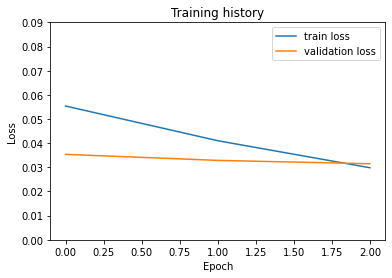

In [31]:
# Plot graphs 
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.09]);

### Generating predictions and metrics

In [ ]:
# Load pretrained model
model = MonoTransQuest(config)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [32]:
# Function to calculate predictions on test set
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  originals = []
  translations = []

  with torch.no_grad():
    for d in data_loader:
      ori = d["original_text"]
      trans = d["translation_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      preds = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      originals.extend(ori)
      translations.extend(trans)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return originals, translations, predictions, real_values

In [33]:
# Get predictions 
originals, translations, predictions, real_values = get_predictions(model,test_data_loader)

preds = predictions.numpy().squeeze()
labels = real_values.numpy().squeeze()
original = np.array(originals)
translation = np.array(translations)

df_results = pd.DataFrame()
df_results['original'] = original
df_results['translation'] = translation
df_results['z_mean'] = labels
df_results['pred_zscore'] = preds

df_results = un_fit(df_results, 'pred_zscore')

df_results.head(30)

,original,translation,z_mean,pred_zscore
0,ඔහු ජෙෆෙර්සන් ගේ දිව්රුම් දීමට ප්‍රථමයෙන් වොෂි...,He was the first to give Jefferson's oath of a...,-1.246499,0.003705
1,මෙම සිතුවම් මගින් පුරාතන රාජධානියේ එදිනෙදා දිව...,These paintings represent the life and cultura...,1.368105,1.238565
2,ප්ලේටෝ ඉදිරිපත් කරන පරිදි මරණාභිමුඛ වූ සොක්‍රට...,"As Plato presents the deathly Socrates, the gr...",0.403440,-0.279472
3,ආසියාවේ වර්ධනය වෙමින් පවතින සමෘධිමත් බවද මෙයට ...,This was a cause of growing prosperity in Asia.,0.472506,0.470448
4,ගුප්තවරුන්ගේ මුල් බිම සම්බන්ධයෙන් විද්වතුන් අත...,The original floor of the mystices has also be...,0.260778,-0.112943
5,මේ තත්වය යෝග අභ්‍යාස මගින් බොහෝ දුරට වළක්වා ගැ...,This situation is mostly prevalent by yoga exe...,0.413922,-0.372492
6,එසේම කාන්තාවන් පුරුෂයන්ටය වඩා අසාමාන්‍ය චර්යාව...,Also women are more likely to have an unusual ...,-0.599468,-0.480774
7,ඇතැම් අවස්ථාවන්හිදී පොදු ජන එක්සත් පෙරමුණ නියෝ...,"In some cases, some parliamentarians represent...",-0.420256,0.893146
8,මේ අතරින් වඩාත්ම ව්‍යසනකාරී වූයේ 874 සිට 884 ද...,The most disastrous among these was the huang ...,1.515809,1.171833
9,මෙය නිෂ්පාදකයා පැවසූ පරිදි 4K ප්‍රක්ෂේපක ක්‍රම...,This was the 4K projection scheme as the produ...,0.228831,0.599359


In [34]:
# Get evaluation metrics
pearson, _ = stats.pearsonr(df_results['pred_zscore'], df_results['z_mean'])
rmse = mean_squared_error(df_results['z_mean'], df_results['pred_zscore'], squared=False)
mae = mean_absolute_error(df_results['z_mean'], df_results['pred_zscore'])
print("Pearson: {}".format(pearson))
print("RMSE: {}".format(rmse))
print("MAE: {}".format(mae))


Pearson: 0.6127661221198769
RMSE: 0.6524848861955165
MAE: 0.5144639736096677


In [35]:
# Save predictions to tsv
df_results.to_csv(results_path, sep = '\t', index=False)